# Evaluation of Lorenz GAN Models

The goal of this notebook is to evaluate the quality of the representation of the Lorenz 96 GAN parameterization.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import keras.backend as K
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from keras.models import load_model
from lorenz_gan.gan import Interpolate1D
import pandas as pd
from scipy.stats import expon, lognorm
import pickle

Using TensorFlow backend.


In [2]:
def normalize_data(data, scaling_values=None):
    """
    Normalize each channel in the 4 dimensional data matrix independently.

    Args:
        data: 4-dimensional array with dimensions (example, y, x, channel/variable)
        scaling_values: pandas dataframe containing mean and std columns

    Returns:
        normalized data array, scaling_values
    """
    normed_data = np.zeros(data.shape, dtype=data.dtype)
    scale_cols = ["mean", "std"]
    if scaling_values is None:
        scaling_values = pd.DataFrame(np.zeros((data.shape[-1], len(scale_cols)), dtype=np.float32),
                                      columns=scale_cols)
    for i in range(data.shape[-1]):
        scaling_values.loc[i, ["mean", "std"]] = [data[:, :, i].mean(), data[:, :, i].std()]
        normed_data[:, :, i] = (data[:, :, i] - scaling_values.loc[i, "mean"]) / scaling_values.loc[i, "std"]
    return normed_data, scaling_values


def unnormalize_data(normed_data, scaling_values):
    """
    Re-scale normalized data back to original values

    Args:
        normed_data: normalized data
        scaling_values: pandas dataframe of mean and standard deviation from normalize_data

    Returns:
        Re-scaled data
    """
    data = np.zeros(normed_data.shape, dtype=normed_data.dtype)
    for i in range(normed_data.shape[-1]):
        data[:, :, i] = normed_data[:, :, i] * scaling_values.loc[i, "std"] + scaling_values.loc[i, "mean"]
    return data

def fit_condition_distributions(train_cond_data):
    """
    Calculate the scale parameter for the exponential distribution of correlated conditional variables
    for the Lorenz 96 model in time.

    Args:
        train_cond_data: array of conditioning values where the first column is the current X, and each
            other column is a lagged X value

    Returns:
        array of scale values
    """
    train_cond_exp_scale = np.zeros(train_cond_data.shape[1] - 1)
    for i in range(1, train_cond_data.shape[1]):
        train_cond_exp_scale[i - 1] = expon.fit(np.abs(train_cond_data[:, 0] - train_cond_data[:, i]), floc=0)[1]
    return train_cond_exp_scale


def generate_random_condition_data(batch_size, num_cond_inputs, train_cond_scale):
    """
    Generate correlated conditional random numbers to train the generator network.

    Args:
        batch_size: number of random samples
        num_cond_inputs: number of conditional inputs
        train_cond_scale: exponential distribution scale values

    Returns:

    """
    batch_cond_data = np.zeros((batch_size, num_cond_inputs, 1))
    batch_cond_data[:, 0, 0] = np.random.normal(size=batch_size)
    for t in range(1, train_cond_scale.size + 1):
        batch_cond_data[:, t , 0] = batch_cond_data[:, 0, 0] + \
                                    np.random.choice([-1, 1], size=batch_size) * expon.rvs(loc=0,
                                                                                           scale=train_cond_scale[t-1],
                                                                                           size=batch_size)
    return batch_cond_data

Load generator model

In [244]:
print(gen_model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 4)             0                                            
____________________________________________________________________________________________________
reshape_1 (Reshape)              (None, 4, 1)          0           input_2[0][0]                    
____________________________________________________________________________________________________
conv1d_1 (Conv1D)                (None, 4, 64)         384         reshape_1[0][0]                  
____________________________________________________________________________________________________
input_1 (InputLayer)             (None, 1)             0                                            
___________________________________________________________________________________________

(1, 8, 32)


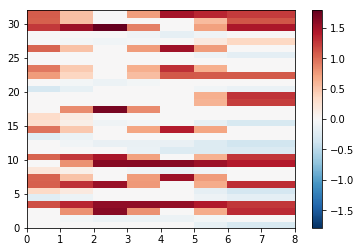

In [284]:
layer_func = K.function(gen_model.input + [K.learning_phase()], [gen_model.layers[10].output])
out = layer_func([np.array([[3]]), np.array([[-2, -1, 0, 1]]), True])[0]
print(out.shape)
#plt.plot(out[0].T)
m_val = np.max(np.abs(out[0].T))
plt.pcolormesh(out[0].T, vmin=-m_val, vmax=m_val, cmap="RdBu_r")
plt.colorbar()

In [42]:
gan_samples = xr.open_dataset("../exp/gan_gen_patches_0000_epoch_0010.nc")
patches = gan_samples["gen_samples"][:, :, 0].values
gan_samples.close()

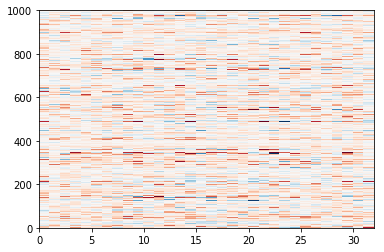

In [43]:
plt.pcolormesh(patches, vmin=-2, vmax=2, cmap="RdBu_r")

(array([  12.,   21.,   51.,  494.,  299.,   68.,   32.,   16.,    5.,    2.]),
 array([-0.13206375, -0.07275748, -0.01345121,  0.04585506,  0.10516133,
         0.1644676 ,  0.22377387,  0.28308014,  0.34238641,  0.40169268,
         0.46099895]),
 <a list of 10 Patch objects>)

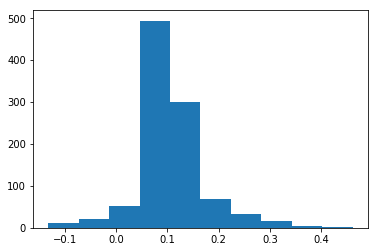

In [227]:
plt.hist(patches[:, 0])

(array([  25.,   68.,   90.,   90.,  112.,  183.,  182.,  150.,   79.,   21.]),
 array([-11.89845657,  -8.94517956,  -5.99190254,  -3.03862553,
         -0.08534851,   2.8679285 ,   5.82120552,   8.77448254,
         11.72775955,  14.68103657,  17.63431358]),
 <a list of 10 Patch objects>)

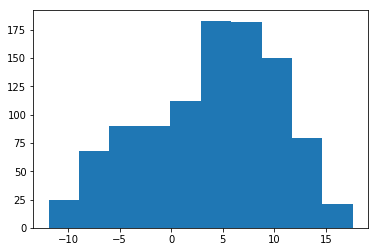

In [232]:
plt.hist(patches.sum(axis=1))

In [328]:
gan_loss = pd.read_csv("../exp/gan_loss_history_0000.csv", index_col="Time")
gan_loss["Epoch_Batch"] = gan_loss["Epoch"].values * gan_loss["Batch"].max() + gan_loss["Batch"].values
gan_loss["Epoch_Batch"] = gan_loss["Epoch_Batch"] / gan_loss["Epoch_Batch"].max() * gan_loss["Epoch"].max()

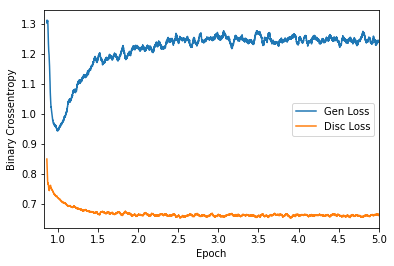

In [329]:

gan_loss[["Gen Loss", "Disc Loss"]].rolling(100).mean().plot(x=gan_loss["Epoch_Batch"].values)
plt.xlabel("Epoch")
plt.ylabel("Binary Crossentropy")

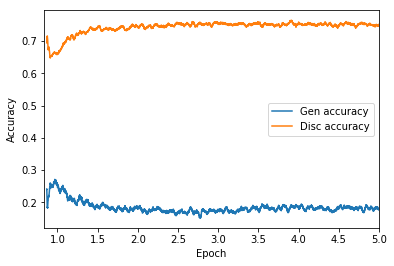

In [330]:
gan_loss[["Gen accuracy", "Disc accuracy"]].rolling(100).mean().plot(x=gan_loss["Epoch_Batch"].values)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

## Evaluate Generator Model

In [361]:
epoch = 10
gen_model = load_model("../exp/gan_generator_0000_epoch_{0:04d}.h5".format(epoch), custom_objects={"Interpolate1D": Interpolate1D})

In [273]:
combined_data = pd.read_csv("../exp/lorenz_combined_output.csv")
y_cols = combined_data.columns[combined_data.columns.str.contains("Y")]
x_cols = combined_data.columns[combined_data.columns.str.contains("X")]
x_cols = ["X_t"]
print(y_cols)
print(x_cols)

Index(['Y_0', 'Y_1', 'Y_2', 'Y_3', 'Y_4', 'Y_5', 'Y_6', 'Y_7', 'Y_8', 'Y_9',
       'Y_10', 'Y_11', 'Y_12', 'Y_13', 'Y_14', 'Y_15', 'Y_16', 'Y_17', 'Y_18',
       'Y_19', 'Y_20', 'Y_21', 'Y_22', 'Y_23', 'Y_24', 'Y_25', 'Y_26', 'Y_27',
       'Y_28', 'Y_29', 'Y_30', 'Y_31'],
      dtype='object')
['X_t']


In [274]:
x_norm, x_scaling = normalize_data(np.expand_dims(combined_data[x_cols].values, axis=-1))
y_norm, y_scaling = normalize_data(np.expand_dims(combined_data[y_cols].values, axis=-1))


In [362]:
pred_func = K.function(gen_model.input + [K.learning_phase()], [gen_model.output])
gan_norm = pred_func([x_norm[:,:,0] , np.random.normal(size=(x_norm.shape[0], 8)), True])[0]
gan_y = unnormalize_data(gan_norm, y_scaling)

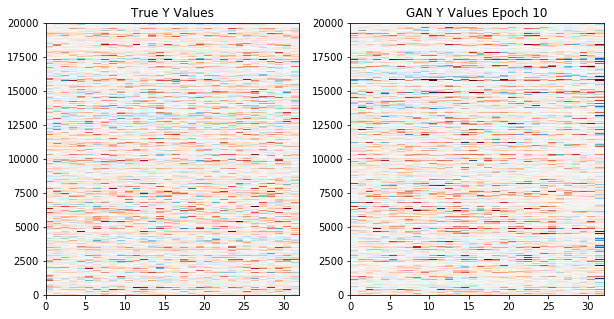

In [363]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].pcolormesh(combined_data[y_cols].values[20000:40000], vmin=-2, vmax=2, cmap="RdBu_r")
axes[0].set_title("True Y Values")
axes[1].pcolormesh(gan_y[20000:40000, :, 0], vmin=-2, vmax=2, cmap="RdBu_r")
axes[1].set_title("GAN Y Values Epoch {0}".format(epoch))
plt.savefig("../exp/gan_y_vals_epoch_{0}.png".format(epoch), bbox_inches="tight", dpi=200)

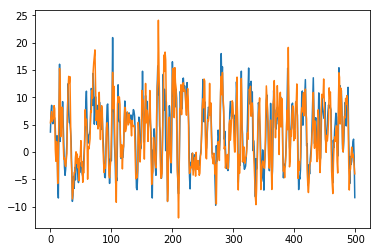

In [364]:
plt.plot(np.arange(0, 500), combined_data[y_cols].sum(axis=1).values[500:1000])
plt.plot(np.arange(0, 500), gan_y[:, :, 0].sum(axis=1)[500:1000])

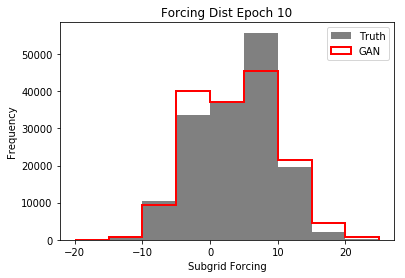

In [365]:
plt.hist(combined_data[y_cols].sum(axis=1).values, bins=np.arange(-20, 30, 5), color="gray", label="Truth")
plt.hist(gan_y[:, :, 0].sum(axis=1), bins=np.arange(-20, 30, 5), histtype='step', lw=2, label="GAN", color="red")
plt.legend()
plt.xlabel("Subgrid Forcing")
plt.ylabel("Frequency")
plt.title("Forcing Dist Epoch {0}".format(epoch))
plt.savefig("../exp/gan_subgrid_hist.png", dpi=200, bbox_inches="tight")

/Users/dgagne/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6497: RuntimeWarning: invalid value encountered in greater
  h[h > cmax] = None
/Users/dgagne/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:929: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


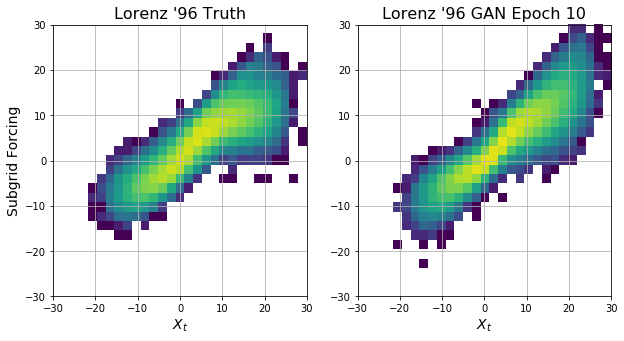

In [366]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
_ = axes[0].hist2d(combined_data["X_t"], combined_data[y_cols].sum(axis=1), bins=[np.linspace(-30, 30, 30), 
                                                                                   np.linspace(-30, 30, 30)], 
                   cmin=1, cmax=10000, norm=LogNorm(1, 10000))
axes[0].set_title("Lorenz '96 Truth", fontsize=16)
_ = axes[1].hist2d(combined_data["X_t"], gan_y[:, :, 0].sum(axis=1), bins=[np.linspace(-30, 30, 30), 
                                                                           np.linspace(-30, 30, 30)], 
                   cmin=1, cmax=10000, norm=LogNorm(1, 10000))
axes[1].set_title("Lorenz '96 GAN Epoch {0}".format(epoch), fontsize=16)
axes[0].set_xlabel("$X_t$", fontsize=14)
axes[1].set_xlabel("$X_t$", fontsize=14)
axes[0].grid()
axes[1].grid()
axes[0].set_ylabel("Subgrid Forcing", fontsize=14)
plt.savefig("../exp/gan_x_u_hist_epoch_{0}.png".format(epoch), dpi=200, bbox_inches="tight")

/Users/dgagne/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6497: RuntimeWarning: invalid value encountered in greater
  h[h > cmax] = None


/Users/dgagne/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:929: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


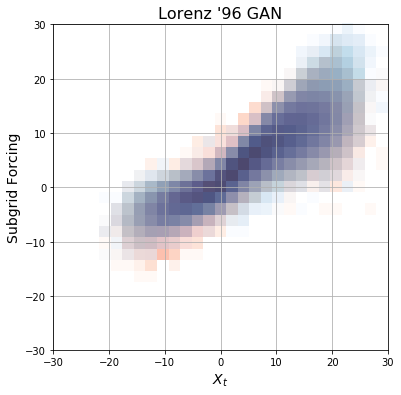

In [321]:
plt.figure(figsize=(6, 6))
_ = plt.hist2d(combined_data["X_t"], combined_data[y_cols].sum(axis=1), bins=[np.linspace(-30, 30, 30), 
               np.linspace(-30, 30, 30)], cmin=1, cmax=10000, norm=LogNorm(1, 10000), cmap="Reds", alpha=0.6)

_ = plt.hist2d(combined_data["X_t"], gan_y[:, :, 0].sum(axis=1), bins=[np.linspace(-30, 30, 30), 
               np.linspace(-30, 30, 30)], cmap="Blues", cmin=1, cmax=10000, norm=LogNorm(1, 10000), alpha=0.6)
plt.grid()
plt.title("Lorenz '96 GAN", fontsize=16)
plt.xlabel("$X_t$", fontsize=14)
plt.ylabel("Subgrid Forcing", fontsize=14)

In [222]:
y_data = combined_data[y_cols].values

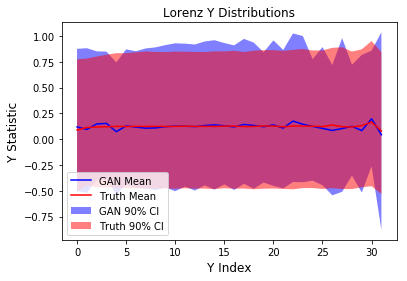

In [367]:
plt.fill_between(np.arange(32), np.percentile(gan_y[:, :, 0], 95, axis=0), 
                 np.percentile(gan_y[:, :, 0], 5, axis=0), alpha=0.5, label="GAN 90% CI", facecolor="blue")
plt.plot(gan_y[:, :, 0].mean(axis=0), label="GAN Mean", color="blue")
plt.fill_between(np.arange(32), np.percentile(y_data, 95, axis=0), 
                 np.percentile(y_data, 5, axis=0), alpha=0.5, facecolor="red", label="Truth 90% CI")
plt.plot(y_data.mean(axis=0), label="Truth Mean", color="red")
plt.legend(loc=3, fontsize=10)
plt.xlabel("Y Index", fontsize=12)
plt.ylabel("Y Statistic", fontsize=12)
plt.title("Lorenz Y Distributions")
plt.savefig("../exp/lorenz_y_dist.png", dpi=200, bbox_inches="tight")

/Users/dgagne/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


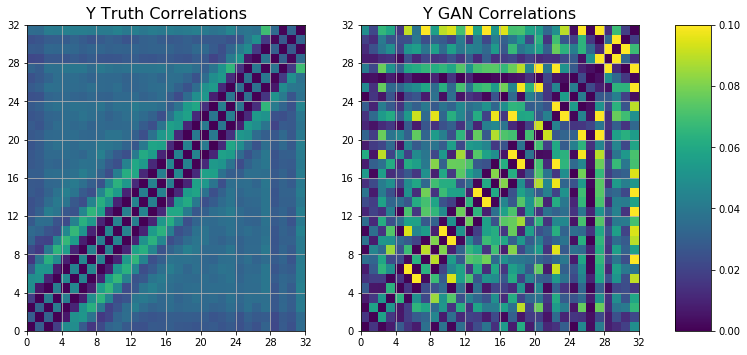

In [368]:
from matplotlib.colors import LogNorm
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plt.subplots_adjust(0.05, 0.05, 0.9, 0.9)
cax = fig.add_axes([0.95, 0.05, 0.05, .85])
truth_corr = np.corrcoef(y_data.T) **2
truth_corr[np.diag_indices(truth_corr.shape[0])] = np.nan
gan_corr = np.corrcoef(gan_y[:, :, 0].T)**2
gan_corr[np.diag_indices(truth_corr.shape[0])] = np.nan
pc = axes[0].pcolormesh(truth_corr, vmin=0, vmax=0.1)
axes[1].pcolormesh(gan_corr, vmin=0, vmax=0.1)
axes[0].set_title("Y Truth Correlations", fontsize=16)
axes[0].set_xticks(np.linspace(0, 32, 9))
axes[1].set_xticks(np.linspace(0, 32, 9))
axes[0].set_yticks(np.linspace(0, 32, 9))
axes[1].set_yticks(np.linspace(0, 32, 9))
axes[0].grid()
axes[1].grid()
axes[1].set_title("Y GAN Correlations", fontsize=16)
plt.colorbar(pc, cax=cax)
plt.savefig("../exp/y_gan_correlations.png", dpi=200, bbox_inches="tight")

## Evaluate Lorenz GAN Forecast

The plots below show the different Lorenz GAN forecasts and how they compare with the truth run.

In [225]:
lorenz_data = xr.open_dataset("../exp/lorenz_output.nc")
x_vals = lorenz_data["lorenz_x"].values
lorenz_data.close()

In [384]:
lorenz_forecasts = []
lorenz_forecast_cube = np.zeros((10, 1001, 8))
for i in range(10):
    lorenz_forecasts.append(pd.read_csv("../exp/lorenz_forecast_{0:02d}.csv".format(i)))
    lorenz_forecast_cube[i] = lorenz_forecasts[i].iloc[:, 2:]

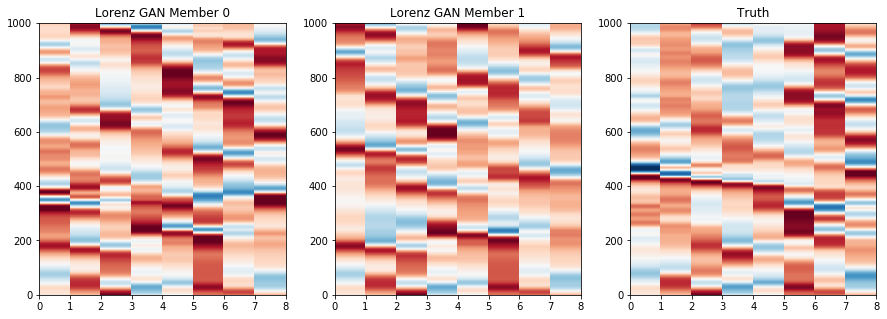

In [385]:
plt.figure(figsize=(15, 5))
for i in range(2):
    plt.subplot(1,3, i + 1)
    plt.pcolormesh(lorenz_forecast_cube[i], vmin=-20, vmax=20, cmap="RdBu_r")
    plt.title("Lorenz GAN Member {0}".format(i))
plt.subplot(1, 3, 3)
plt.pcolormesh(x_vals[100000:100000 + 1001, :], vmin=-20, vmax=20, cmap="RdBu_r")
plt.title("Truth")

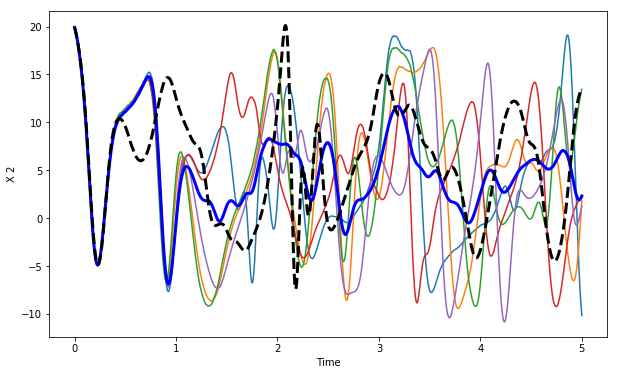

In [388]:
plt.figure(figsize=(10, 6))
x_val = 2
for i in range(5):
    plt.plot(lorenz_forecasts[0]["time"], lorenz_forecasts[i]["X_{0}".format(x_val)], "-")

plt.plot(lorenz_forecasts[0]["time"], np.mean([lorenz_forecasts[i]["X_{0}".format(x_val)] for i in range(10)], axis=0), 'b-', lw=3)

plt.plot(lorenz_forecasts[0]["time"], x_vals[100000:100000 + 1001, x_val], 'k--', lw=3)
plt.xlabel("Time")
plt.ylabel("X {0}".format(x_val))

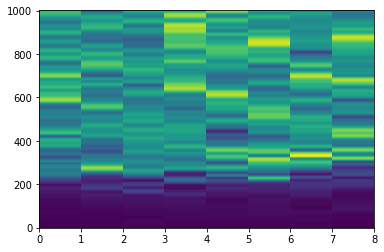

In [376]:
plt.subplots(1, 1, )
plt.pcolor(lorenz_forecast_cube.std(axis=0))

In [159]:
np.percentile(lorenz_forecast_cube[:, :, x_val], 90, axis=0).shape

(1001,)

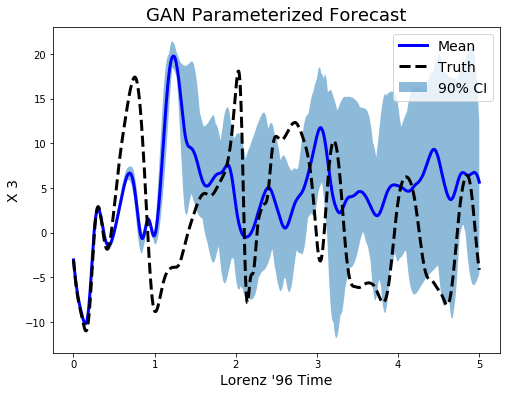

In [377]:
plt.figure(figsize=(8, 6))
x_val = 3
plt.fill_between(lorenz_forecasts[0]["time"],
                 np.percentile(lorenz_forecast_cube[:, :, x_val], 95, axis=0), 
                 np.percentile(lorenz_forecast_cube[:, :, x_val], 5, axis=0), alpha=0.5, label="90% CI")
plt.plot(lorenz_forecasts[0]["time"], lorenz_forecast_cube[:, :, x_val].mean(axis=0), color="blue", lw=3, label="Mean")
plt.plot(lorenz_forecasts[0]["time"], x_vals[100000:100000 + 1001, x_val], 'k--', lw=3, label="Truth")
plt.xlabel("Lorenz '96 Time", fontsize=14)
plt.ylabel("X {0:d}".format(x_val), fontsize=14)
plt.legend(loc=0, fontsize=14)
plt.title("GAN Parameterized Forecast", fontsize=18)
plt.savefig("../exp/lorenz_forecast_ts.png", dpi=200, bbox_inches="tight")